In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Sequential 
from tensorflow.keras.utils import Sequence, to_categorical, plot_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, MaxPooling2D, concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from random import sample, choice
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

In [13]:
! pip install -q kaggle

In [14]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [15]:
! cp kaggle.json ~/.kaggle/

In [16]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [17]:
 ! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              229KB  2021-06-01 11:18:46           6999  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           4209  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1403  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           2161  
mathurinache/twitter-edge-nodes                             Twitter Edge Nod

In [18]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [19]:
!kaggle datasets download -d jcoral02/camvid

100% 1.12G/1.12G [00:05<00:00, 243MB/s]
100% 1.12G/1.12G [00:05<00:00, 232MB/s]


In [20]:
%cd /content
!unzip camvid.zip

/content
Archive:  camvid.zip
  inflating: CamVid/class_dict.csv   
  inflating: CamVid/test/0001TP_008550.png  
  inflating: CamVid/test/0001TP_008580.png  
  inflating: CamVid/test/0001TP_008610.png  
  inflating: CamVid/test/0001TP_008640.png  
  inflating: CamVid/test/0001TP_008670.png  
  inflating: CamVid/test/0001TP_008700.png  
  inflating: CamVid/test/0001TP_008730.png  
  inflating: CamVid/test/0001TP_008760.png  
  inflating: CamVid/test/0001TP_008790.png  
  inflating: CamVid/test/0001TP_008820.png  
  inflating: CamVid/test/0001TP_008850.png  
  inflating: CamVid/test/0001TP_008880.png  
  inflating: CamVid/test/0001TP_008910.png  
  inflating: CamVid/test/0001TP_008940.png  
  inflating: CamVid/test/0001TP_008970.png  
  inflating: CamVid/test/0001TP_009000.png  
  inflating: CamVid/test/0001TP_009030.png  
  inflating: CamVid/test/0001TP_009060.png  
  inflating: CamVid/test/0001TP_009090.png  
  inflating: CamVid/test/0001TP_009120.png  
  inflating: CamVid/test/0001TP_

In [21]:
train_images = os.listdir('/content/CamVid/train')
valid_images = os.listdir('/content/CamVid/val')
test_images = os.listdir('/content/CamVid/test')
print(f"Size of train images {len(train_images)}\nSize of validation images {len(valid_images)}\nSize of test images {len(test_images)}")

Size of train images 367
Size of validation images 101
Size of test images 233


In [22]:
train_pairs = []
for im in train_images:
  train_pairs.append(('/content/CamVid/train/' + im, '/content/CamVid/train_labels/' + im.split('.')[0]+'_L.png'))

valid_pairs = []
for im in valid_images:
  valid_pairs.append(('/content/CamVid/val/' + im, '/content/CamVid/val_labels/' + im.split('.')[0]+'_L.png'))

test_pairs  = []
for im in test_images:
  test_pairs.append(('/content/CamVid/test/' + im, '/content/CamVid/test_labels/' + im.split('.')[0]+'_L.png'))
        

random image:  /content/CamVid/train/0016E5_07560.png


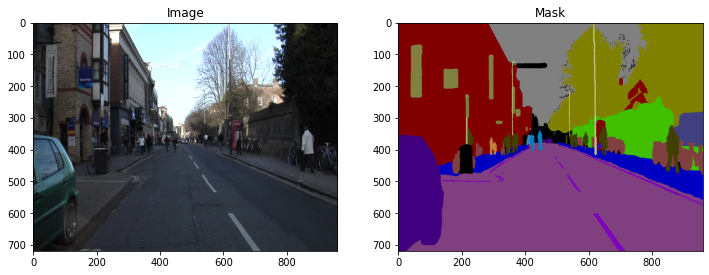

In [35]:
randomTrainImage = choice(train_pairs) 
print("random image: ",randomTrainImage[0])

img = img_to_array(load_img(randomTrainImage[0]))
mask = img_to_array(load_img(randomTrainImage[1]))
plt.figure(figsize=(12,12))
plt.subplot(121)
plt.title("Image")
plt.imshow(img/255)
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask/255)

In [24]:
def form_2D_label(mask,class_map):
    mask = mask.astype("uint8")
    label = np.zeros(mask.shape[:2],dtype= np.uint8)
    
    for i, rgb in enumerate(class_map):
        label[(mask == rgb).all(axis=2)] = i
    
    return label

In [25]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    
    def __init__(self, pair,class_map,  batch_size=16, dim=(224,224,3), shuffle=True):
        'Initialization'
        self.dim = dim
        self.pair = pair
        self.class_map = class_map
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.pair) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        list_IDs_temp = [k for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.pair))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_imgs = list()
        batch_labels = list()
        for i in list_IDs_temp:
            img = load_img(self.pair[i][0] ,target_size=self.dim)
            img = img_to_array(img)/255.
            batch_imgs.append(img)

            label = load_img(self.pair[i][1],target_size=self.dim)
            label = img_to_array(label)
            #------ comment these two lines to see proper working of datagenerator in cell below----#
            label = form_2D_label(label,self.class_map)
            label = np.asarray(to_categorical(label , num_classes = 32))
            batch_labels.append(label)
        return np.array(batch_imgs) ,np.array(batch_labels)

In [45]:
class_map_df = pd.read_csv("/content/CamVid/class_dict.csv")
class_map_df.head()
class_map = []
for index,item in class_map_df.iterrows():
    class_map.append(np.array([item['r'], item['g'], item['b']]))

train_generator = DataGenerator(train_pairs, class_map, batch_size=4, dim=(512,512,3) ,shuffle=True)
val_generator   = DataGenerator(valid_pairs, class_map, batch_size=4, dim=(512,512,3) ,shuffle=True)
test_generator  = DataGenerator(test_pairs,  class_map, batch_size=4, dim=(512,512,3) ,shuffle=True)

In [46]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y

def Unet(h, w, filters, num_classes):

    input_layer = Input(shape=(h, w, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
    output_layer = Conv2D(filters=num_classes, kernel_size=(1, 1), activation='softmax')(deconv9)

    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model

In [47]:
model = Unet(512 , 512 , 64, 32)
model.summary()

Model: "Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 512, 512, 64) 1792        image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 512, 512, 64) 256         conv2d_10[0][0]                  
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 512, 512, 64) 0           batch_normalization_10[0][0]     
_______________________________________________________________________________________________

In [48]:
model.compile(optimizer='adam', loss='categorical_crossentropy' ,metrics=['accuracy'])
modelCheckpoint = ModelCheckpoint(mode='max', filepath='top-weights.h5', monitor='val_acc',save_best_only='True', verbose=1)
earlyStopping = EarlyStopping(monitor='val_acc', patience=10, verbose=0)
trainedModel = model.fit_generator(train_generator , steps_per_epoch=train_generator.__len__() , epochs=35,
                                   validation_data=val_generator,validation_steps=val_generator.__len__(),callbacks=[modelCheckpoint,earlyStopping],
                                   verbose = 1)

Epoch 1/35
91/91 [==============================] - 207s 2s/step - loss: 1.4871 - accuracy: 0.6254 - val_loss: 15.7948 - val_accuracy: 0.3922
Epoch 2/35
91/91 [==============================] - 158s 2s/step - loss: 1.0231 - accuracy: 0.7105 - val_loss: 1.7506 - val_accuracy: 0.5577
Epoch 3/35
91/91 [==============================] - 159s 2s/step - loss: 0.8693 - accuracy: 0.7566 - val_loss: 2.0797 - val_accuracy: 0.4308
Epoch 4/35
91/91 [==============================] - 158s 2s/step - loss: 0.7986 - accuracy: 0.7748 - val_loss: 1.7358 - val_accuracy: 0.5738
Epoch 5/35
91/91 [==============================] - 158s 2s/step - loss: 0.7609 - accuracy: 0.7837 - val_loss: 1.3462 - val_accuracy: 0.6758
Epoch 6/35
91/91 [==============================] - 159s 2s/step - loss: 0.7173 - accuracy: 0.7965 - val_loss: 1.4191 - val_accuracy: 0.6438
Epoch 7/35
91/91 [==============================] - 159s 2s/step - loss: 0.6991 - accuracy: 0.8007 - val_loss: 0.9295 - val_accuracy: 0.7766
Epoch 8/35
9

In [49]:
model.evaluate_generator(test)

[0.7678157687187195, 0.7847074270248413]

In [67]:
x_test, y_test = test_generator.__getitem__(1)
y_pred = model.predict(x_test, verbose = 1, batch_size = 4)

1/1 [==============================] - 0s 23ms/step


In [68]:
def map_rgb(y_pred,class_map):
    y_pred_rgb = np.zeros((y_pred.shape[0],y_pred.shape[1],y_pred.shape[2],3))
    for i in range(y_pred.shape[0]):
        image = np.zeros((y_pred.shape[1],y_pred.shape[2],3))
        for j in range(y_pred.shape[1]):
            for k in range(y_pred.shape[2]):
                image[j,k,:] = class_map[y_pred[i][j][k]]
        y_pred_rgb[i] = image
    return y_pred_rgb
def plot_result(img , title):
    plt.figure(figsize=(12, 6))
    plt.title(title)
    for i in range(4):
        plt.subplot(2, 4, i+1)
        plt.imshow(img[i])
    plt.show()
pred = np.argmax(y_pred, axis=3)
y_pred_rgb = map_rgb(pred,class_map)
test = np.argmax(y_test, axis=3)
y_test_rgb = map_rgb(test,class_map)

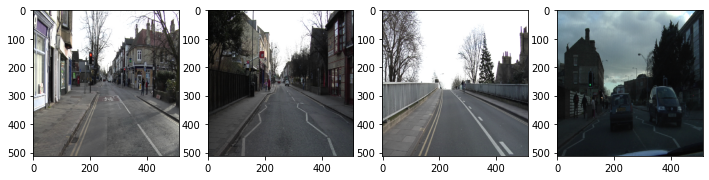

In [69]:
plot_result(x_test,"Test Images")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


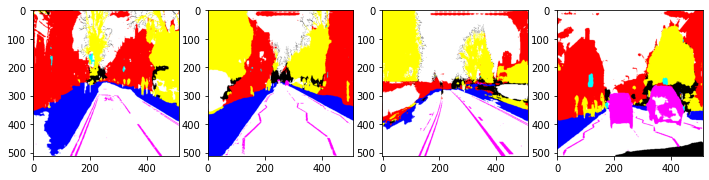

In [70]:
plot_result(y_pred_rgb,"Predicted mask")

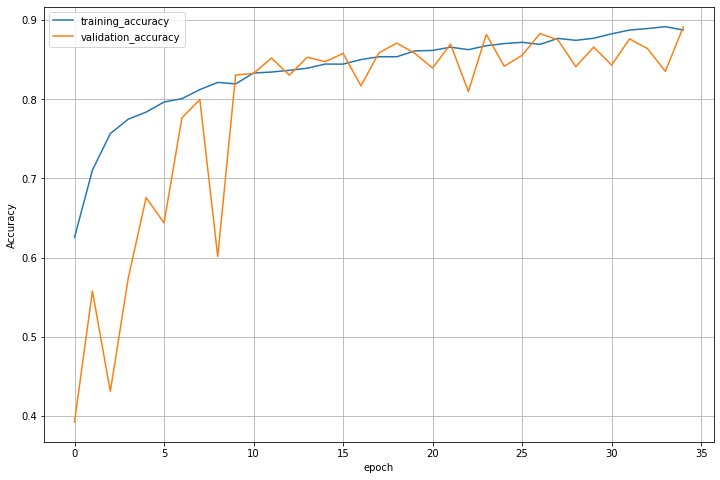

In [73]:
plt.figure(figsize=(12,8))
plt.plot(trainedModel.history['accuracy'], label = 'training_accuracy')
plt.plot(trainedModel.history['val_accuracy'], label = 'validation_accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

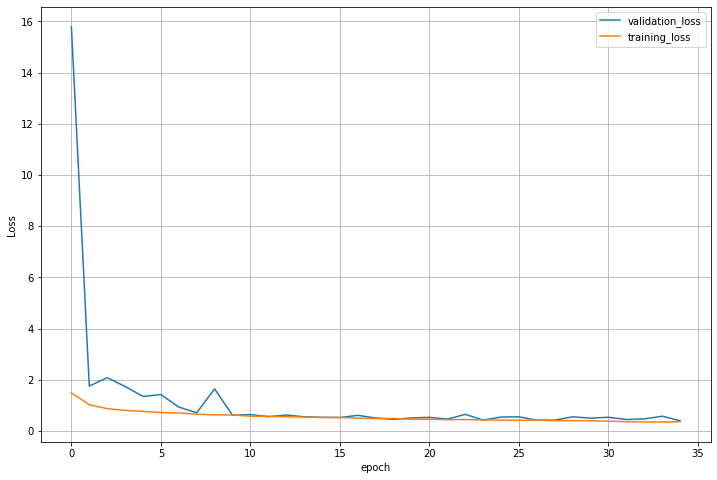

In [75]:
plt.figure(figsize=(12,8))
plt.plot(trainedModel.history['val_loss'], label = 'validation_loss')
plt.plot(trainedModel.history['loss'], label = 'training_loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)